In [2]:
import pandas as pd

# import data
movieData = pd.read_csv(r"C:\Users\junjq\Downloads\movie_metadata.csv")
print movieData.columns.values
print 'total number of movie before cleaning is ' + str(len(movieData))
print movieData.describe()
print movieData.info()

['color' 'director_name' 'num_critic_for_reviews' 'duration'
 'director_facebook_likes' 'actor_3_facebook_likes' 'actor_2_name'
 'actor_1_facebook_likes' 'gross' 'genres' 'actor_1_name' 'movie_title'
 'num_voted_users' 'cast_total_facebook_likes' 'actor_3_name'
 'facenumber_in_poster' 'plot_keywords' 'movie_imdb_link'
 'num_user_for_reviews' 'language' 'country' 'content_rating' 'budget'
 'title_year' 'actor_2_facebook_likes' 'imdb_score' 'aspect_ratio'
 'movie_facebook_likes']
total number of movie before cleaning is 5043
       num_critic_for_reviews     duration  director_facebook_likes  \
count             4993.000000  5028.000000              4939.000000   
mean               140.194272   107.201074               686.509212   
std                121.601675    25.197441              2813.328607   
min                  1.000000     7.000000                 0.000000   
25%                 50.000000    93.000000                 7.000000   
50%                110.000000   103.000000   

I am interested in what affect movie imdb scores and its gross box office. <br/><br/>
I will first use the numerical data presented in the dataset to analyze the possible relationships.<br/><br/>
Then, I will try to analyze the categorical features and see if there are any possible relationship.<br/><br/>

In [3]:
# remove unessasary data
movieData.drop(["aspect_ratio", "movie_imdb_link"], inplace=True, axis=1)

# clean duplicates
movieData = movieData.drop_duplicates()

# drop na
movieData = movieData.dropna()

# since 95.8 perc of the movie is in english, we can delete language column
print((movieData['language'].value_counts()/len(movieData)).head())
movieData.drop(['language'], inplace=True, axis=1)

print len(movieData)

English     0.958090
French      0.009019
Spanish     0.006101
Mandarin    0.003714
German      0.002653
Name: language, dtype: float64
3770


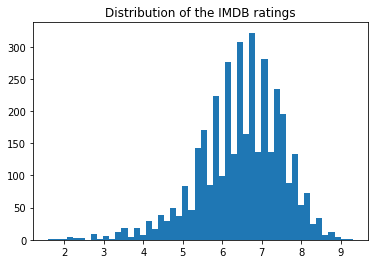

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

imdb_score = movieData['imdb_score']
movieData.drop(['imdb_score'], inplace=True, axis=1)
plt.hist(imdb_score, bins=50)
plt.title("Distribution of the IMDB ratings")
plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler 

# we first start analyzing data with numeric data
numeric_features=movieData._get_numeric_data().columns.values.tolist()
for x in ['title_year']: numeric_features.remove(x) 
movieDataNum = movieData[numeric_features]

# standardize the data
scl=StandardScaler()
movieDataNum = pd.DataFrame(scl.fit_transform(movieDataNum), columns = numeric_features)

print movieDataNum.mean()
print movieDataNum.std()

num_critic_for_reviews       1.822886e-17
duration                     8.135255e-16
director_facebook_likes      8.261149e-16
actor_3_facebook_likes      -8.956879e-17
actor_1_facebook_likes       1.697522e-15
gross                        3.183719e-16
num_voted_users              3.515608e-16
cast_total_facebook_likes    5.074632e-16
facenumber_in_poster         1.657678e-16
num_user_for_reviews         3.243500e-16
budget                      -5.300063e-17
actor_2_facebook_likes       4.926357e-16
movie_facebook_likes        -4.556332e-15
dtype: float64
num_critic_for_reviews       1.000133
duration                     1.000133
director_facebook_likes      1.000133
actor_3_facebook_likes       1.000133
actor_1_facebook_likes       1.000133
gross                        1.000133
num_voted_users              1.000133
cast_total_facebook_likes    1.000133
facenumber_in_poster         1.000133
num_user_for_reviews         1.000133
budget                       1.000133
actor_2_facebook_like

Text(0.5,1,'correlation heatmap of numeric features')

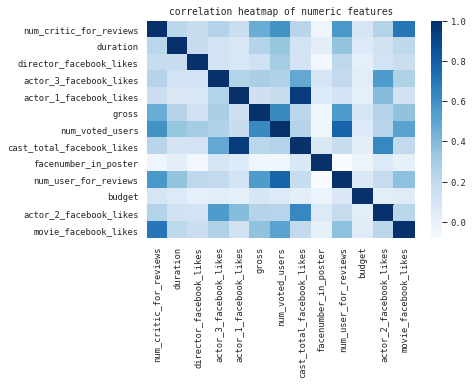

In [6]:
import seaborn as sns
movieDataCorr = movieDataNum.corr()
sns.set(context="paper", font="monospace")
sns.heatmap(movieDataCorr, cmap="Blues")
plt.title('correlation heatmap of numeric features')

It appears that actors facebook likes are highly correlated with the total facebook likes. We will drop total like and use actor 1 like and other like (which is a sum of actor 2 and 3 like).

It also appears that movie facebook like, num of critic, gross, num voted users, num user for review are all pairwise correlated. I will create a new category called popularity as an average of the five categories.

In [7]:
movieDataNum['other_facebook_likes'] = movieDataNum['actor_2_facebook_likes'] + movieDataNum['actor_3_facebook_likes'] 
movieDataNum.drop(['actor_2_facebook_likes','actor_3_facebook_likes','cast_total_facebook_likes'], inplace=True, axis=1)
movieDataNum['popularity'] = (movieDataNum['num_voted_users'] + movieDataNum['num_critic_for_reviews'] + movieDataNum['num_user_for_reviews'] + movieDataNum['gross'] + movieDataNum['movie_facebook_likes'])/5
movieDataNum.drop(['num_voted_users','num_critic_for_reviews','num_user_for_reviews','gross','movie_facebook_likes'], inplace=True, axis=1)

Text(0.5,1,'correlation heatmap of adjusted numeric features')

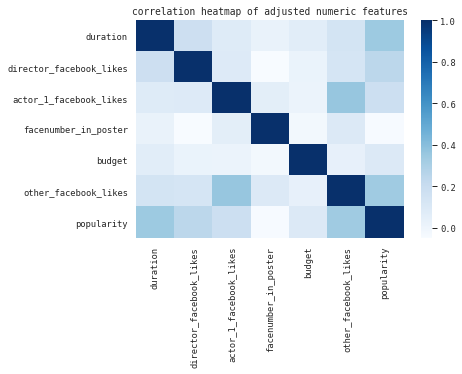

In [8]:
movieDataCorr = movieDataNum.corr()
sns.set(context="paper", font="monospace")
sns.heatmap(movieDataCorr, cmap="Blues")
plt.title('correlation heatmap of adjusted numeric features')

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(movieDataNum, imdb_score, 
                                                    test_size=0.20, random_state=0)

n_folds = 3

from sklearn.model_selection import KFold

kf = KFold(n_splits=n_folds)
kf = kf.get_n_splits(x_train)

print ('Training Random Forest...')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

clf_rf = RandomForestRegressor(n_estimators=100,max_depth=15) 
clf_rf = clf_rf.fit( x_train, y_train )
classifier_score = clf_rf.score(x_test, y_test)
print ('The classifier accuracy score is {:.2f}'.format(classifier_score))
# Get average of 3-fold cross-validation score 
score = cross_val_score(clf_rf, x_test, y_test, cv=kf)
print ('The {}-fold cross-validation accuracy score for this classifier is {:.2f}'.format(n_folds, score.mean()))

feature_imp = clf_rf.feature_importances_
feature_imp = pd.Series(feature_imp,
                       index = movieDataNum.columns).sort_values()
print feature_imp

Training Random Forest...


C:\Users\junjq\Anaconda2\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


The classifier accuracy score is 0.35
The 3-fold cross-validation accuracy score for this classifier is 0.23
facenumber_in_poster       0.038978
actor_1_facebook_likes     0.082315
director_facebook_likes    0.086594
other_facebook_likes       0.102856
budget                     0.174748
duration                   0.189584
popularity                 0.324925
dtype: float64


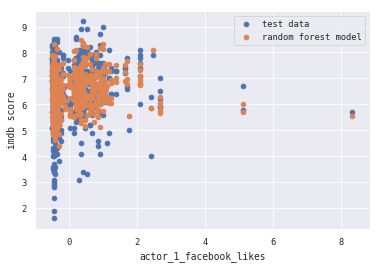

In [10]:
x =x_test['actor_1_facebook_likes']
y = clf_rf.predict(x_test)

plt.figure()
plt.scatter(x, y_test, label="test data")
plt.scatter(x, y, label="random forest model")
plt.xlabel("actor_1_facebook_likes")
plt.ylabel("imdb score")
plt.legend()
plt.show()

Insights<br/><br/>

The most important factor that affects movie rating is the movie popularity, which is not surprising. The second importance is duration. The longer the movie is, the higher the rating will be.
Budget is important, although there is no strong correlation between budget and movie rating.
The facebook popularity of director is an important factor to affect a movie rating.
The facebook popularity of the other actors/actresses is important.
The number of faces in movie poster has a least important effect to the movie rating.<br/><br/>
In addition, we will take a look at what affecting the gross box office<br/><br/>
Later, we will assess how categorical data also have an affect on rating and profitability of the movie

In [20]:
# gross = np.log(movieData['gross'])
gross = movieData['gross']

from sklearn.model_selection import train_test_split
movieDataNum2 = movieDataNum.drop(['popularity'], axis = 1)
x_train2, x_test2, y_train2, y_test2 = train_test_split(movieDataNum2, gross, 
                                                    test_size=0.20, random_state=0)

n_folds = 3

from sklearn.model_selection import KFold

kf = KFold(n_splits=n_folds)
kf = kf.get_n_splits(x_train2)

print ('Training Random Forest...')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

clf_rf2 = RandomForestRegressor(n_estimators=100,max_depth=15) 
clf_rf2 = clf_rf2.fit( x_train2, y_train2)
classifier_score2 = clf_rf2.score(x_test2, y_test2)
# ols = linear_model.LinearRegression()
# ols = ols.fit( x_train, y_train )
# ols_score = ols.score(x_test, y_test)
print ('The classifier accuracy score is {:.2f}'.format(classifier_score2))
# Get average of 3-fold cross-validation score 
score = cross_val_score(clf_rf2, x_test, y_test, cv=kf)
print ('The {}-fold cross-validation accuracy score for this classifier is {:.2f}'.format(n_folds, score.mean()))


feature_imp = clf_rf2.feature_importances_
feature_imp = pd.Series(feature_imp,
                       index = movieDataNum2.columns).sort_values()
print feature_imp


Training Random Forest...
The classifier accuracy score is 0.40
The 3-fold cross-validation accuracy score for this classifier is 0.23
facenumber_in_poster       0.031576
director_facebook_likes    0.090895
actor_1_facebook_likes     0.096638
duration                   0.129739
other_facebook_likes       0.142967
budget                     0.508185
dtype: float64


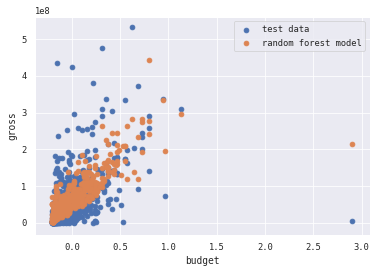

In [12]:
x =x_test['budget']
y = clf_rf2.predict(x_test2)

plt.figure()
plt.scatter(x, y_test2, label="test data")
plt.scatter(x, y, label="random forest model")
plt.xlabel("budget")
plt.ylabel("gross")
plt.legend()
plt.show()


Insights <br/><br/>
The most important factor that affects movie gross box office is the movie budget, which is not surprising. The ore budget of a movie, the more it need in box office to pay back. Facebook like of the actors and duration will also have an effect on the movie's gross box office.<br/><br/>

In addition, since our precision rate is not very high, we will simplify the problem a little. Instead of predicting the numerical score of the moview, I will try to make two categories, good movie and bad movie. I will use the same numeric feature set and assess if I can predict a good movie from bad movie
<br/><br/>
Later, we will assess how categorical data also have an affect on rating and profitability of the movie<br/><br/>

Training SVM...
The classifier accuracy score is 0.66
The 3-fold cross-validation accuracy score for this classifier is 0.68


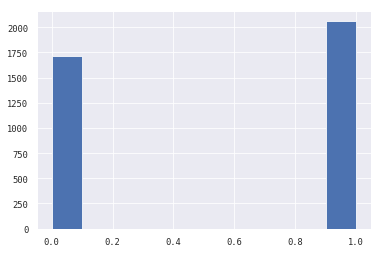

In [21]:
from sklearn.model_selection import train_test_split

imdb_score_cat = imdb_score.copy()
imdb_score_cat[imdb_score>=6.5] = 1
imdb_score_cat[imdb_score<6.5] = 0

imdb_score_cat.hist()

x_train3, x_test3, y_train3, y_test3 = train_test_split(movieDataNum, imdb_score_cat, 
                                                    test_size=0.20, random_state=0)

n_folds = 3

from sklearn.model_selection import KFold

kf = KFold(n_splits=n_folds)
kf = kf.get_n_splits(x_train3)

print ('Training SVM...')
from sklearn import svm
from sklearn.model_selection import cross_val_score

svm_mv = svm.SVC(kernel='linear', probability=True)
svm_mv = svm_mv.fit(x_train3, y_train3)
classifier_score = svm_mv.score(x_test3, y_test3)
decision_score = svm_mv.decision_function(x_test3)
print ('The classifier accuracy score is {:.2f}'.format(classifier_score))
# Get average of 3-fold cross-validation score 
score = cross_val_score(svm_mv, x_test3, y_test3, cv=kf)
print ('The {}-fold cross-validation accuracy score for this classifier is {:.2f}'.format(n_folds, score.mean()))

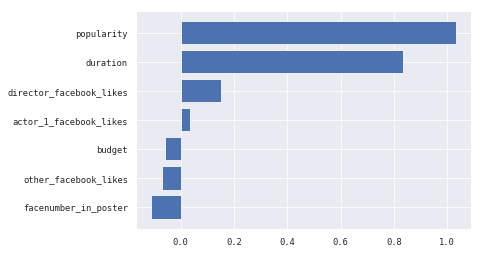

In [22]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
f_importances(svm_mv.coef_[0], list(movieDataNum.columns))

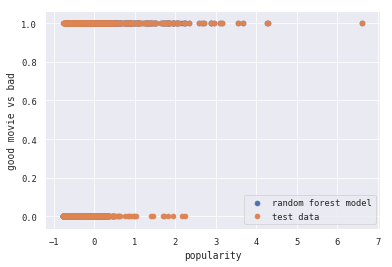

In [23]:
x =x_test3['popularity']
y = svm_mv.predict(x_test3)

plt.figure()
plt.scatter(x, y, label="random forest model")
plt.scatter(x, y_test3, label="test data")

plt.xlabel("popularity")
plt.ylabel("good movie vs bad")
plt.legend()
plt.show()

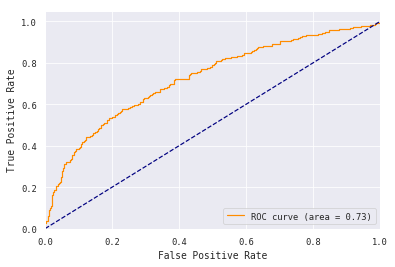

In [24]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test3, decision_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
          label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

Now, include more categorical features. I think genres is a good start to analyze

In [26]:
categorical_features =[x for x in movieData.columns if (x not in numeric_features) & ('name' not in x)]
categorical_features.remove('movie_title')
categorical_features.remove('plot_keywords')

print categorical_features

['color', 'genres', 'country', 'content_rating', 'title_year', 'sci-fi', 'family', 'horror', 'fantasy', 'adventure', 'western', 'sport', 'thriller', 'mystery', 'romance', 'war', 'film-noir', 'crime', 'drama', 'animation', 'music', 'biography', 'action', 'comedy', 'documentary', 'musical', 'history']


In [27]:
movieData['genres'].apply(lambda x: x.split('|'))

0                    [action, adventure, fantasy, sci-fi]
1                            [action, adventure, fantasy]
2                           [action, adventure, thriller]
3                                      [action, thriller]
5                             [action, adventure, sci-fi]
6                            [action, adventure, romance]
7       [adventure, animation, comedy, family, fantasy...
8                             [action, adventure, sci-fi]
9                   [adventure, family, fantasy, mystery]
10                            [action, adventure, sci-fi]
11                            [action, adventure, sci-fi]
12                                    [action, adventure]
13                           [action, adventure, fantasy]
14                           [action, adventure, western]
15                   [action, adventure, fantasy, sci-fi]
16                   [action, adventure, family, fantasy]
17                            [action, adventure, sci-fi]
18            

In [47]:
import numpy as np

# get all genres
genres = set()
for g in movieData['genres'].apply(lambda x:x.lower().split('|')):
    genres=genres.union(set(g))


for g in genres:
    movieData[g] = movieData['genres'].apply(lambda gs: 1 if g in gs.split('|') else 0)

genres_score = {}
profit_score = {}
roi_score={}
for g in genres:
    genres_score[g] = sum(movieData[g]*imdb_score)/sum(movieData[g])
    profit_score[g] = sum(movieData[g]*(movieData['gross']-movieData['budget']))/sum(movieData[g])
    roi_score[g] = np.sum(movieData[g]*(movieData['gross']-movieData['budget']))/np.sum(movieData[g]*movieData['budget'])/sum(movieData[g])
print "all unique genres are:"+ str(genres)
    
genres_score_p = {}
profit_score_p = {}
roi_score_p={}
popular_genres = [x for x in genres if sum(movieData[x]) > 500]
for g in popular_genres:
    genres_score_p[g] = sum(movieData[g]*imdb_score)/sum(movieData[g])
    profit_score_p[g] = sum(movieData[g]*(movieData['gross']-movieData['budget']))/sum(movieData[g])
    roi_score_p[g] = np.sum(movieData[g]*(movieData['gross']-movieData['budget']))/np.sum(movieData[g]*movieData['budget'])/sum(movieData[g])
print "Tpp 8 unique genres are:"+ str(popular_genres)    
    

all unique genres are:set(['sci-fi', 'family', 'horror', 'history', 'fantasy', 'adventure', 'musical', 'sport', 'thriller', 'mystery', 'drama', 'film-noir', 'crime', 'romance', 'animation', 'music', 'biography', 'action', 'comedy', 'documentary', 'war', 'western'])
Tpp 8 unique genres are:['fantasy', 'adventure', 'thriller', 'drama', 'crime', 'romance', 'action', 'comedy']


([<matplotlib.axis.XTick at 0xddeee48>,
 <a list of 22 Text xticklabel objects>)

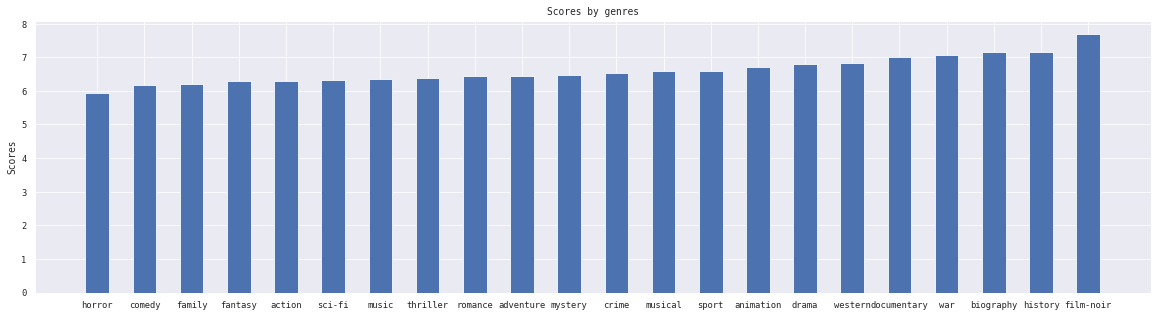

In [39]:
ax = plt.subplots(1,1, figsize=(20,5))
plt.bar(range(len(genres)),pd.Series(genres_score).sort_values(),0.5)
plt.ylabel('Scores')
plt.title('Scores by genres')
plt.xticks(range(len(genres)), pd.Series(genres_score).sort_values().index)

([<matplotlib.axis.XTick at 0x1218d7f0>,
 <a list of 22 Text xticklabel objects>)

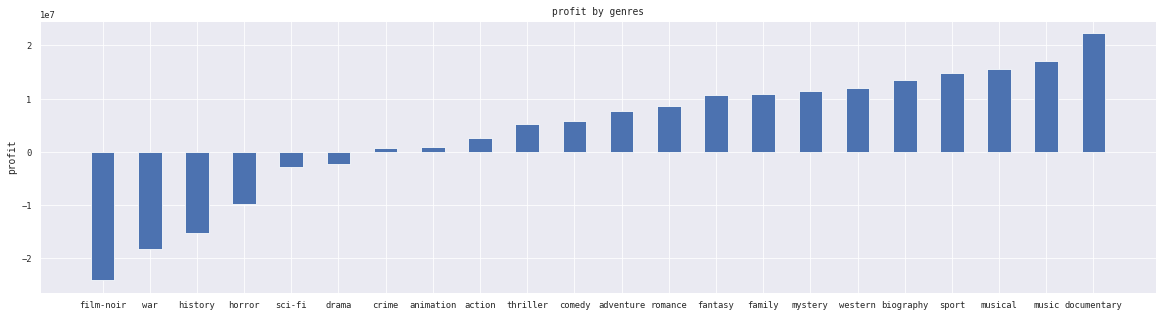

In [40]:
ax = plt.subplots(1, figsize=(20,5))
plt.bar(range(len(genres)),pd.Series(profit_score).sort_values(),0.5)
plt.ylabel('profit')
plt.title('profit by genres')
plt.xticks(range(len(genres)), pd.Series(roi_score).sort_values().index)

([<matplotlib.axis.XTick at 0x129609b0>,
 <a list of 8 Text xticklabel objects>)

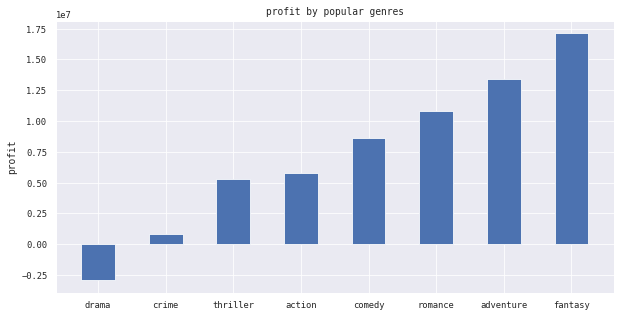

In [41]:
ax = plt.subplots(1, figsize=(10,5))
plt.bar(range(len(popular_genres)),pd.Series(profit_score_p).sort_values(),0.5)
plt.ylabel('profit')
plt.title('profit by popular genres')
plt.xticks(range(len(popular_genres)), pd.Series(profit_score_p).sort_values().index)

([<matplotlib.axis.XTick at 0x12e305f8>,
 <a list of 8 Text xticklabel objects>)

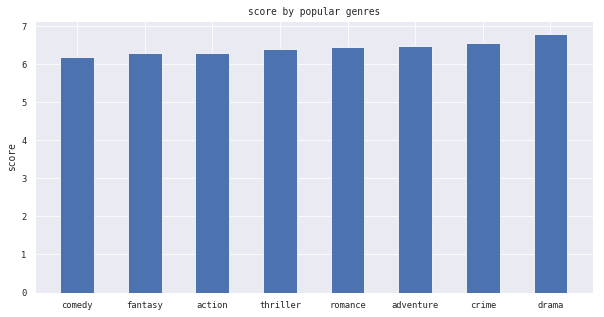

In [42]:
ax = plt.subplots(1, figsize=(10,5))
plt.bar(range(len(popular_genres)),pd.Series(genres_score_p).sort_values(),0.5)
plt.ylabel('score')
plt.title('score by popular genres')
plt.xticks(range(len(popular_genres)), pd.Series(genres_score_p).sort_values().index)

([<matplotlib.axis.XTick at 0x12303ac8>,
 <a list of 8 Text xticklabel objects>)

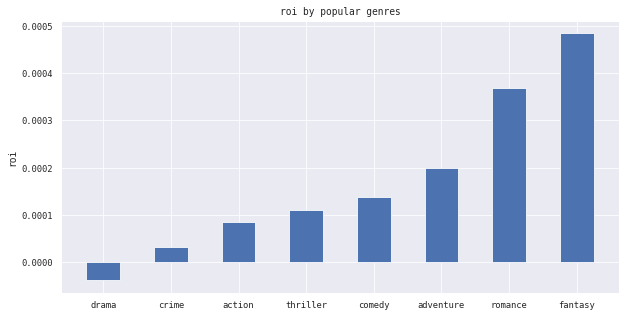

In [43]:
ax = plt.subplots(1, figsize=(10,5))
plt.bar(range(len(popular_genres)),pd.Series(roi_score_p).sort_values(),0.5)
plt.ylabel('roi')
plt.title('roi by popular genres')
plt.xticks(range(len(popular_genres)), pd.Series(roi_score_p).sort_values().index)

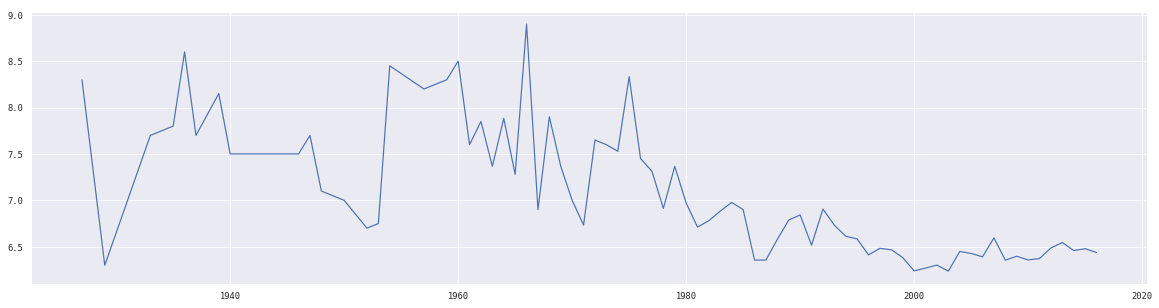

In [44]:
year_score = pd.concat([imdb_score, movieData['title_year']],axis=1).groupby('title_year').mean().sort_index()
ax = plt.subplots(1, figsize=(20,5))
plt.plot(year_score)